In [193]:
import keras
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8, 6)

In [ ]:
!cat WISDM_ar_v1.1_raw.txt | awk -F',' 'BEGIN { OFS=","; RS=";"; ORS=";"; } \
{ if (NF==6) { print $0,"" } else if (NF==7) { print $0 }}' > raw_data_fixed.txt

In [194]:
DATA_FOLDER = 'Data/WISDM_ar_v1.1/'
DATA_FILE = 'raw_data_fixed.txt'

In [195]:
actitracker = pd.read_csv(
    DATA_FOLDER+DATA_FILE ,
    sep=',' ,
    lineterminator=';' ,
    header=None ,
)

In [196]:
actitracker.columns = [
    'user' ,
    'activity' ,
    'timestamp' ,
    'x-accel' ,
    'y-accel' ,
    'z-accel' ,
    'NA' ,
]
del actitracker['NA']

In [197]:
actitracker[['x-accel','y-accel','z-accel']].describe()

,x-accel,y-accel,z-accel
count,1098208.000000,1098208.000000,1098208.000000
mean,0.662866,7.255626,0.411078
std,6.849046,6.746216,4.754120
min,-19.610000,-19.610000,-19.800000
25%,-2.870000,3.170000,-2.220000
50%,0.270000,7.930000,0.000000
75%,4.440000,11.560000,2.720000
max,19.950000,20.040000,19.610000


In [198]:
sample = np.random.choice(xrange(actitracker.shape[0]), 2000)

In [199]:
X, Y, Z = actitracker[['x-accel']].as_matrix()[sample].ravel() , \
actitracker[['y-accel']].as_matrix()[sample].ravel() , \
actitracker[['z-accel']].as_matrix()[sample].ravel()

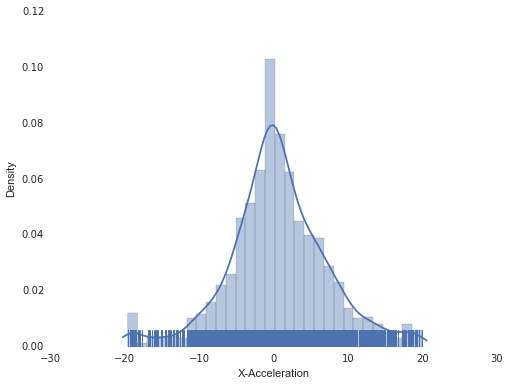

In [231]:
sns.distplot(X, bins=30, rug=True)
sns.axlabel('X-Acceleration','Density')

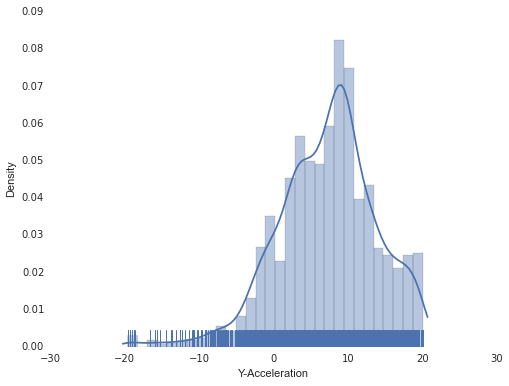

In [230]:
sns.distplot(Y, bins=30, rug=True)
sns.axlabel('Y-Acceleration','Density')

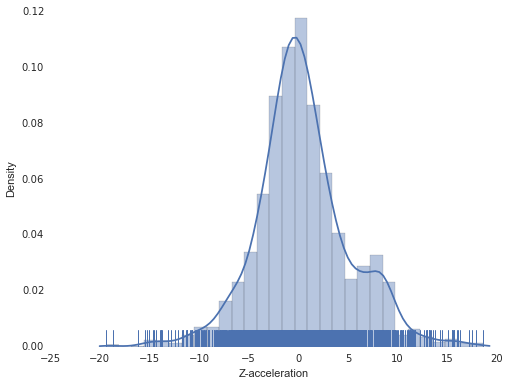

In [229]:
sns.distplot(Z, bins=30, rug=True)
sns.axlabel('Z-Acceleration','Density')

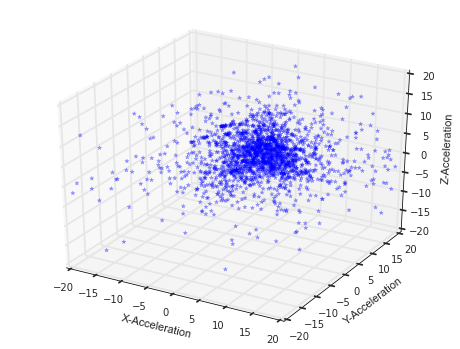

In [228]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
lims = [-20,20]
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_zlim(lims)
ax.set_xlabel('X-Acceleration')
ax.set_ylabel('Y-Acceleration')
ax.set_zlabel('Z-Acceleration')
plt.scatter(X, Y, zs=Z, axes=ax, marker='*', color='blue', alpha=0.4)

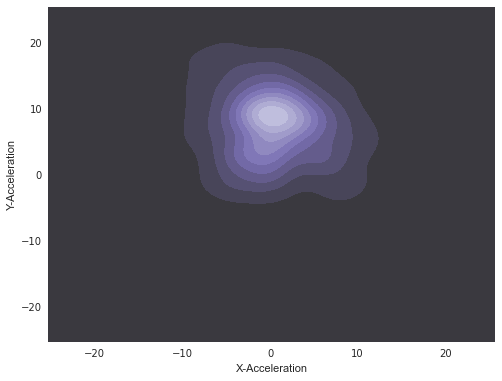

In [213]:
sns.kdeplot(
    X ,
    Y ,
    cmap="Purples_d" ,
    shade=True ,
)
sns.axlabel('X-Acceleration','Y-Acceleration')


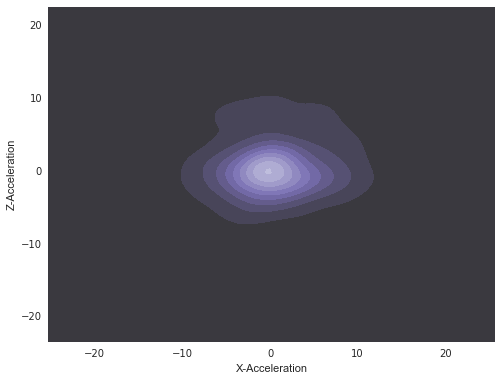

In [221]:
sns.kdeplot(
    X ,
    Z ,
    cmap="Purples_d" ,
    shade=True ,
)
sns.axlabel('X-Acceleration','Z-Acceleration')

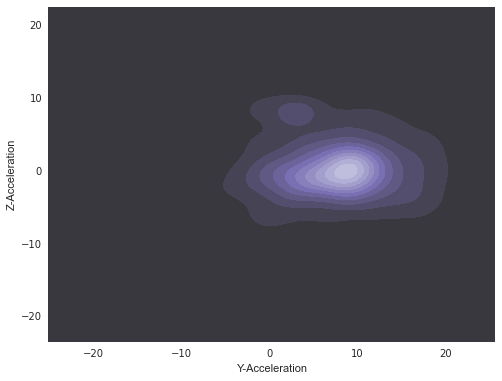

In [222]:
sns.kdeplot(
    Y ,
    Z ,
    cmap="Purples_d" ,
    shade=True ,
)
sns.axlabel('Y-Acceleration','Z-Acceleration')

In [207]:
D = actitracker.iloc[sample][['x-accel','y-accel','z-accel','activity']]

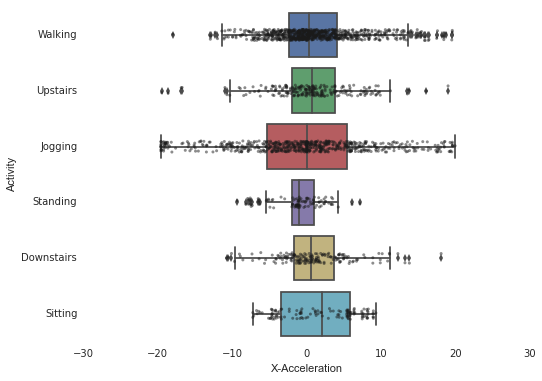

In [223]:
sns.boxplot(x='x-accel',y='activity',data=D)
sns.stripplot(x="x-accel", y="activity", data=D,
              jitter=True, size=3, color=".1", alpha=0.5, linewidth=0)
sns.axlabel('X-Acceleration','Activity')

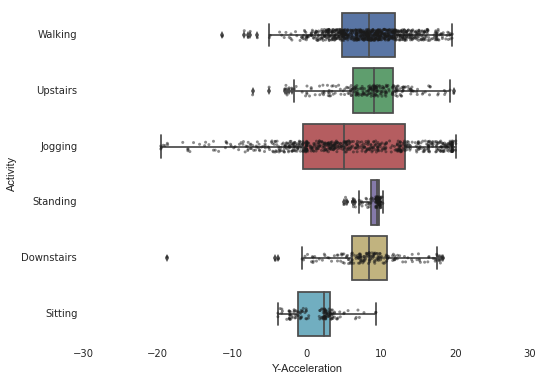

In [224]:
sns.boxplot(x='y-accel',y='activity',data=D)
sns.stripplot(x="y-accel", y="activity", data=D,
              jitter=True, size=3, color=".1", alpha=0.5, linewidth=0)
sns.axlabel('Y-Acceleration','Activity')

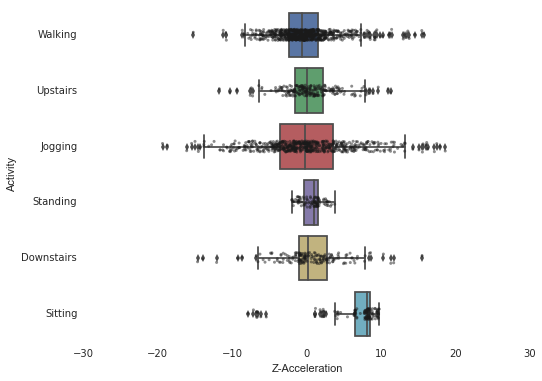

In [225]:
sns.boxplot(x='z-accel',y='activity',data=D)
sns.stripplot(x="z-accel", y="activity", data=D,
              jitter=True, size=3, color=".1", alpha=0.5, linewidth=0)
sns.axlabel('Z-Acceleration','Activity')